# Measuring Churn

### Data Import and Packages

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [5]:
# importing raw csv file as pandas dataframe
df = pd.read_csv('../data/raw/BankChurners.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

## Churn Rate

### Calculating churn rate

Customers who no longer use the service are considered churners. At a point in time prior to the time at which measurements were taken in the data, a number of customers equal to the sumber of rows $10127$ signed up for the service. Once the data was generated, a portion of those customers were retained, and another portion churned. The *churn rate* is thus the proportion of total customers who have left the service:  

$$ChurnRate=\frac{\#ChurnedCustomers}{\#StartingCustomers}$$

The data tells us that some customers have churned, so we can look at these proportions to calculate the churn rate.

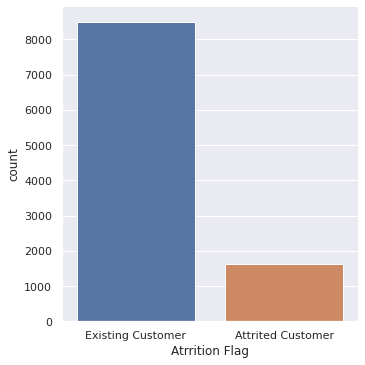

In [25]:
# plotting values of Attrition_Flag column
g = sns.catplot(data=df, kind='count', x='Attrition_Flag')
g.set_axis_labels('Atrrition Flag')
plt.show()

In [14]:
# number of churned customers
CC = df[df['Attrition_Flag'] =='Attrited Customer'].shape[0]
print('# Churned Customers = {}'.format(CC))

# number of starting (total) customers
SC = df.shape[0]
print('# Starting Customers = {}'.format(SC))

#churn rate
CR = CC/SC
print('Churn Rate = {}%'.format(round(CR, 3)))

# Churned Customers = 1627
# Starting Customers = 10127
Churn Rate = 0.161%


Plugging in these numbers to the churn rate formula:  

$$ChurnRate=\frac{1627}{10127}=0.161\%$$

Since the data does not include date variables, we are making an assumption that all accounts included in the data were new users at around the same time. This is necessary for calculating churn, because the churn rate should not include newly acquired accounts. The churn rate is exclusively focused on the set of customers that were acquired at the same time (or at least within a reasonably small time window). We can also calculate the retention rate by looking at the proportion of existing customers over total customers:

$$RetentionRate=\frac{\#ExistingCustomers}{\#StartingCustomers}$$

In [16]:
# number of existing customers
CC = df[df['Attrition_Flag'] =='Existing Customer'].shape[0]
print('# Existing Customers = {}'.format(CC))
print('# Starting Customers = {}'.format(SC))

#churn rate
RR = CC/SC
print('Retention Rate = {}%'.format(round(RR, 3)))

# Existing Customers = 8500
# Starting Customers = 10127
Retention Rate = 0.839%


### Relationship between churn and retention

Plugging into the formula:
$$RetentionRate=\frac{8500}{10127}=0.839\%$$

Since customers fall either under `Existing Customer` or `Attrited Customer`, it makes sense that the retention rate is the opposite of the churn rate. Let's explore this relationship.  
The number of starting customers is composed by both customers who churn and customers who are retained:

$$\#StartingCustomers = \#ChurnedCustomers + \#ExistingCustomers$$

We'll use shorter abbreviations for these variables from now on. The three terms in the equation are $Start$, $Churn$, and $Retention$ respectively. We can divide both sides of the equation by $\#StartingCustomers$ to get $1$ on the left-hand side:

$$\frac{Start}{Start}=\frac{Churn}{Start} + \frac{Retention}{Start}$$

The fractions on the right-hand side of the equation were already defined as the churn rate and the retention rate, which leads to the following identity:

$$100\%=ChurnRate+RetentionRate$$

Since $ChurnRate$ and $RetentionRate$ add up to $100\%$, calculating one will lead to the other and it doesn't make a difference which one is used for analysis. We will stick with churn rate since the purpose of this analysis is to reduce churn.

## Churn Data

Some datasets on customer churn might contain more columns than the data used for this analysis, but there are some required keys that are needed for churn analysis:

- *Account ID* - This variable defines unique accounts. Keep in mind that the same account can be using multiple services. Current dataset name: `CLIENTNUM`
- *Product ID* - Identifies which product corresponds to the data in that row. For the current dataset, we assume all rows refer to the same product (credit card)
- *Start Date* - The date in which the customer began using the product. For the current datset, we assume all customers have the same start date or at least close enough to each other.
- *End Date* - The date in which the customer churned. If they didn't churn, there is not date. For the current dataset, we assume `Attrition_Flag` was measured at the same time for all customers.  

This data can come from multiple sources. For credit cards, there is normally a database with all transactions, another one with the customer's file, and another with application data. For example, in this dataset, a variable like `Total_Trans_Amt` will come from a transaction database, `Credit_Limit` from the customer file, and `Education_Level` from the credit application data. To obtain a table similar to the one here, these data sources must be merged on the keys mentioned above.

## Net Retention

Before moving on to calculating churn metrics, it's import to define a *Monthly recurring revenue (MRR)* variable from the data. In the context of credit cards, a financial institution makes money when accountholders carry their balance over at least one billing cycle. The dataset here does not have historical information on this, but `Total_Revolving_Bal` tells us the the total revolving balance on the credit card. For simplicity, let's assume that all credit cards have an APR of 24% and thus a simple monthly interest rate of $2\%$. In this context, we can approximate the revenue that the financial institution makes on the credit card by taking $2\%$ of the total revolving balance for each account. Since there is another variable `Card_Category` that specifies the type of card (Blue, Silver, Gold, Platinum), we'll assume that this is only for difference in credit limit and not in APR.

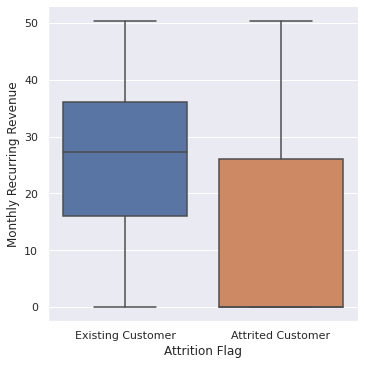

In [34]:
# estimating monthly recurring revenue
df.loc[:, 'Monthly_Recurring_Rev'] = df['Total_Revolving_Bal'] * 0.02

# plotting averages
g = sns.catplot(data = df, x='Attrition_Flag', y='Monthly_Recurring_Rev', kind='box')
g.set_axis_labels('Attrition Flag', 'Monthly Recurring Revenue')
plt.show()

### Calculating net retention

With MRR calculated, we can derive a basic metric called net retention. Net retention is measured over a specific time window, which in this case is the time windows in which the accounts were measured to produce the data. *Net retention rate (NRR)* is the proportion of recurring revenue from existing customers over the recurring revenue from all customers at the start date (remember start date is implicitly the same for all accounts in this example). Net retention is an appropriate churn metric because it doesn't include newly acquired accounts. It can also include current changes in revenue streams for existing customres, but we will ignore that for simplicity.

$$NetRetention=\frac{MRR_{retention}}{MRR_{start}}$$

This is slightly different to how we calculated $ChurnRate$ and $RetentionRate$ before, since this metric gives more wait to customers that have a higher MRR.

In [43]:
# calculting MRR_retention
MRR_retention = df[df['Attrition_Flag'] == 'Existing Customer']['Monthly_Recurring_Rev'].sum()
print('MRR Retention = ${}'.format(MRR_retention))

# calculating MRR_start
MRR_start = df['Monthly_Recurring_Rev'].sum()
print('MRR Start = ${}'.format(MRR_start))

# calculating Net Retention Rate
NRR =  MRR_retention / MRR_start
print('Net Retention Rate = {}'.format(round(NRR, 3)))

# calculating Net Churn Rate
NCR = 1 - NRR
print('Net Churn Rate = {}'.format(round(NCR, 3)))

MRR Retention = $213622.7
MRR Start = $235516.36
Net Retention Rate = 0.907
Net Churn Rate = 0.093


Plugging into the formula:

$$NetRetention=\frac{\$213,622.70}{\$235,516.36}=0.907\%$$

Just like before, we can also calculate a *Net Churn Rate* by subtracting $100\%$ from the *Net Retetion Rate*:

$$NetChurn=100\%-NetRetention=0.093\%$$

### Interpretation of net retention

Here we made an assumption that all customers pay the same interest rate, but even so the revenue that they generated depended on their revolving balance. This is why the MRR churn is slightly different than the count-based churn calculations in the previous section. In other words, it only makes sense to calculate net retention when the service is not free and when different customers pay different amounts for using the service, which holds true for credit cards. There are four ways that customer revenue can change:

- a new account is opened
- a customer churns and stops using their account
- upsell: an existing customer generates more revenue (charged a higher interest or has a higher revolving balance)
- downsell: an existing customer generates less revenue (charged a lower interest or has a smaller revolving balance)

Upsells can offset churn, but in the context of credit cards, it might not always happen. This is because charging a higher interest will motivate customers to change to another financial institution that charges them less. At the same time, revolving balance depends on a multitude of factors that are unique to the customer, so it is not always reliable to expect customer to carry higher balances in the future.  

In the context of fighting churn, however, net retention has its limits. This is because upsells and downsells occur at different rates and magnitudes for the product as a whole, which the metric does not account for. Including upsells in the calculation is preferable because when customers churn, the potential revenue from upselling is lost. Even if it might not be as useful for data analysis, net retention is useful for external reporting, and it is a metric that is easily understood by investors. This is because it summarizes all revenue changes into one metric. Also, as mentioned before, upselling can increase revenue in a way that offsets the decreases in revenue from churning and downselling. This is known as *negative churn*. This desirable case occurs when $NetRetention > 100\%$, which results in $NetChurn < 0\%$

## Account-Based Churn

Let's go back to the initial $ChurnRate$ calculated as the proportion of customers who have cancelled their credit cards.